# Giới thiệu vấn đề
  1. Các sàn forex thường có những chương trình khuyến mãi tặng thưởng cho người chơi. Khi 2 người chơi cùng mở 1 lệnh ở cùng một thời điểm nhưng ngược nhau BUY vs SELL thì một người sẽ lời và một người sẽ lỗ với số tiền tương ứng như nhau. Khi đó thì sàn sẽ bị lỗ rất nhiều nếu không ngăn chặn được.
  2. Dữ liệu được lấy từ kho dữ liệu của sàn. Và được lấy trực tiếp từ các lệnh đang giao dịch trên sàn bằng cách quét tất cả các giao dịch hiện tại và đưa ra những giao dịch khả nghi.
  3. Các bước thực hiện
    1.   Đánh giá các giao dịch, đưa ra các list giao dịch khả nghi.
    2.   Xác định các giao dịch đối xứng với giao dịch khả nghi đó. VD: nếu 1 tài khoản SELL 100VND được đánh giá là khả nghi thì tìm ra cặp đối xứng BUY 100VND. Việc dò tìm cặp đối xứng này tốn khá nhiều thời gian.
    3. Nếu tìm ra được cặp đối xứng thì sẽ báo cáo là 2 tài khoản gian lận trong cùng sàn. Ngược lại, nếu không tìm được thì sẽ báo cáo là gian lận với một sàn khác. Việc báo cáo này dựa trên kinh nghiệm và trực giác, chủ quan của người đánh giá.
    4. Do việc gian lận có thể được người chơi thực hiện bằng nhiều hình thức khác nhau. VD: 1 tài khoản có thể chơi gian lận với 2 tài khoản khác. Hoặc nhiều loại tiền khác nhau. Hoặc có thể xử dụng **TOOLS** để mở nhiều lệnh rất nhỏ. Vì vậy mô hình có thể bị bỏ xót các giao dịch như vậy. Xây dựng một mô hình đánh giá mức độ giống nhau của các lệnh đang mở trên sàn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ML_Model as md
import ML_Phantich as pt
import ML_Transform as mt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("Data Modeling/Data_2_bonus.csv")

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (9,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.rename(columns={'Symbol':'Volume',"Volume":'Symbol'},inplace=True)

In [4]:
df.head(5)

,Account,Ticket,Time,Type,Volume,Symbol,Open Price,S / L,T / P,Close Time,Close Price,Commission,Taxes,Swap,Profit,Balance,Bonus,Target
0,5353407,61928436.0,2020.11.09 07:19:04,buy,3.0,usdjpy,103.460,103.3,0.0,2020.11.09 14:00:41,104.181,0,0,0,216 300,500000.0,1000000.0,1
1,5353407,61953817.0,2020.11.09 14:00:49,sell,4.0,usdjpy,104.179,0.0,0.0,2020.11.09 16:49:32,105.235,0,0,0,-422 400,500000.0,1000000.0,1
2,5353407,61966332.0,2020.11.09 14:57:08,sell,4.0,usdjpy,104.860,0.0,0.0,2020.11.09 16:53:44,105.261,0,0,0,-160 400,500000.0,1000000.0,1
3,5353407,61966335.0,2020.11.09 14:57:11,sell,4.0,usdjpy,104.859,0.0,0.0,2020.11.09 16:53:42,105.266,0,0,0,-162 800,500000.0,1000000.0,1
4,5353407,61966341.0,2020.11.09 14:57:13,sell,4.0,usdjpy,104.854,0.0,0.0,2020.11.09 16:53:15,105.255,0,0,0,-160 400,500000.0,1000000.0,1


In [5]:
df.shape

(87946, 18)

In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(87265, 18)

# Xem xét các biến
## Loại bỏ biến
    1.Biến Close Price, Close Time, Profit rất quan trọng trong việc đánh giá 2 giao dịch có gian lận hay không. Bởi vì nếu 2 giao dịch mở cùng một thời gian và có số tiền thưởng giống nhau sẽ có 2 trường hợp xảy ra :
    2. Nếu 2 giao dịch đó đóng cùng thời gian, profit lời/lỗ tương đương nhau, Close Price bằng nhau thì sẽ được đánh giá là gian lận.
    3. Ngược lại, sẽ đánh giá là giao dịch do 2 người chơi mở ngẫu nhiên. Nhưng do hệ thống xây dựng trên mô hình trực tuyến khi các lệnh còn đang mở, chưa biết được khi nào các giao dịch đóng lệnh vì vậy các giá trị Close Price, Close Time, Profit cũng không thể lấy được trên hệ thống. -> Bỏ cả 3 biến này.
    4. Dựa vào kinh nghiệm làm việc thì ta sẽ loại bỏ các biến bao gồm : S / L, T / P, Commission, Taxes,Swap. Các biến này không liên quan đến việc đánh giá giao dịch gian lận hay không.

In [7]:
df.describe()

,Account,Ticket,Volume,Open Price,S / L,T / P,Close Price,Commission,Taxes,Balance,Bonus,Target
count,8.822600e+04,3.435000e+03,88226.000000,8.820300e+04,88226.000000,88210.000000,88147.000000,88226.0,88226.0,8.822600e+04,8.822600e+04,88226.00000
mean,1.231265e+08,5.705994e+07,0.543314,8.829626e+02,0.098718,1.488511,5.603160,0.0,0.0,7.343175e+05,4.618634e+05,0.03983
std,9.536398e+07,6.421491e+06,2.024708,1.063301e+05,9.588444,42.084956,80.894786,0.0,0.0,1.727865e+06,8.480604e+05,0.19556
min,1.059700e+04,2.178810e+06,0.010000,1.000000e-05,0.000000,0.000000,0.000000,0.0,0.0,-1.717014e+06,2.000000e-01,0.00000
25%,5.350453e+06,5.479026e+07,0.010000,1.202000e+00,0.000000,0.000000,0.000000,0.0,0.0,3.063425e+04,2.000000e+04,0.00000
50%,2.000945e+08,5.983849e+07,0.050000,1.040690e+02,0.000000,0.000000,0.000000,0.0,0.0,2.000000e+05,1.355000e+05,0.00000
75%,2.001559e+08,6.113455e+07,0.250000,1.084305e+02,0.000000,0.000000,0.000000,0.0,0.0,7.400000e+05,5.100000e+05,0.00000
max,2.002194e+08,6.377423e+07,140.000000,2.993001e+07,1965.000000,1989.000000,1966.290000,0.0,0.0,4.921817e+07,9.020000e+06,1.00000


In [47]:
df.columns

Index(['Account', 'Ticket', 'Time', 'Type', 'Volume', 'Symbol', 'Open Price',
       'S / L', 'T / P', 'Close Time', 'Close Price', 'Commission', 'Taxes',
       'Swap', 'Profit', 'Balance', 'Bonus', 'Target'],
      dtype='object')

In [14]:
df_analyze = df[['Type','Symbol','Volume','Balance','Bonus','Target']]

In [15]:
df_analyze.head()

,Type,Symbol,Volume,Balance,Bonus,Target
0,sell,usdjpy,5.0,900000.0,910000.0,1
1,sell,usdjpy,2.0,900000.0,910000.0,1
2,sell,usdjpy,4.0,900000.0,910000.0,1
3,sell,usdjpy,3.0,900000.0,910000.0,1
4,sell,usdjpy,2.0,900000.0,910000.0,1


## Phân tích biến volume

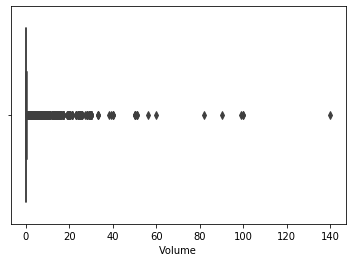

In [16]:
sb.boxplot(df_analyze.Volume)

In [17]:
df_analyze.Volume.describe()

count    88195.000000
mean         0.543489
std          2.025042
min          0.010000
25%          0.010000
50%          0.050000
75%          0.250000
max        140.000000
Name: Volume, dtype: float64

In [18]:
lower,upper,df_now,df_index = pt.xem_ngoai_le(df_analyze,'Volume')

In [19]:
print("Lower : {} , Upper : {}".format(lower,upper))

Lower : -0.35 , Upper : 0.61


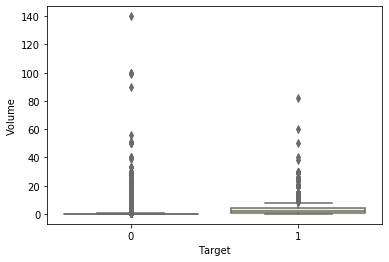

In [20]:
sb.boxplot(x='Target',y='Volume',data=df_analyze,palette="Set3")

In [21]:
st = "Volume" + "~ C(" + "Target" + ")"
model =ols(st,data=df_analyze[['Volume','Target']]).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print(anova_table)

                  sum_sq       df            F  PR(>F)
C(Target)   28201.981621      1.0  7458.735497     0.0
Residual   333463.677057  88193.0          NaN     NaN


In [22]:
df_analyze[df_analyze.Target==1].Volume.describe()

count    3514.000000
mean        3.319428
std         4.549818
min         0.050000
25%         1.000000
50%         2.000000
75%         4.000000
max        82.000000
Name: Volume, dtype: float64

In [23]:
df_analyze[df_analyze.Target==1].Volume.quantile([0.05,0.95])

0.05     0.500
0.95    13.175
Name: Volume, dtype: float64

In [24]:
df_analyze[df_analyze.Target==0].Volume.describe()

count    84681.000000
mean         0.428296
std          1.754748
min          0.010000
25%          0.010000
50%          0.040000
75%          0.200000
max        140.000000
Name: Volume, dtype: float64

In [25]:
df_analyze[df_analyze.Target==0].Volume.quantile([0.05,0.95])

0.05    0.01
0.95    2.00
Name: Volume, dtype: float64

### Kết luận biến volume
    1. Biến volume này có rất nhiều ngoại lệ. Với ngoại lệ upper là 0.61. Khi phân tích thì ta thấy được những ngoại lệ này phần lớn thuộc về những class 1 với Q1 = 1 và Q2 = 4. Đây là một điều kiện để classifi class 0 và class 1. Ngược lại ở class 0 thì gần như các mẫu đều rơi vào trường hợp volume <= 1.
    2. Phân tích này cho thấy phần lớn các người chơi đều đặt với volume rất nhỏ. Chỉ có một số người chơi đặt ở volume cao là những người chơi chuyên nghiệp hoặc những giao dịch gian lận

## Phân tích biến Symbol

In [22]:
df_symbol = df_analyze.groupby(by=['Symbol'])['Type'].count().reset_index().sort_values(by="Type",ascending=False).rename(columns={"Type":"Count","Symbol":"Currency"}).head(8)

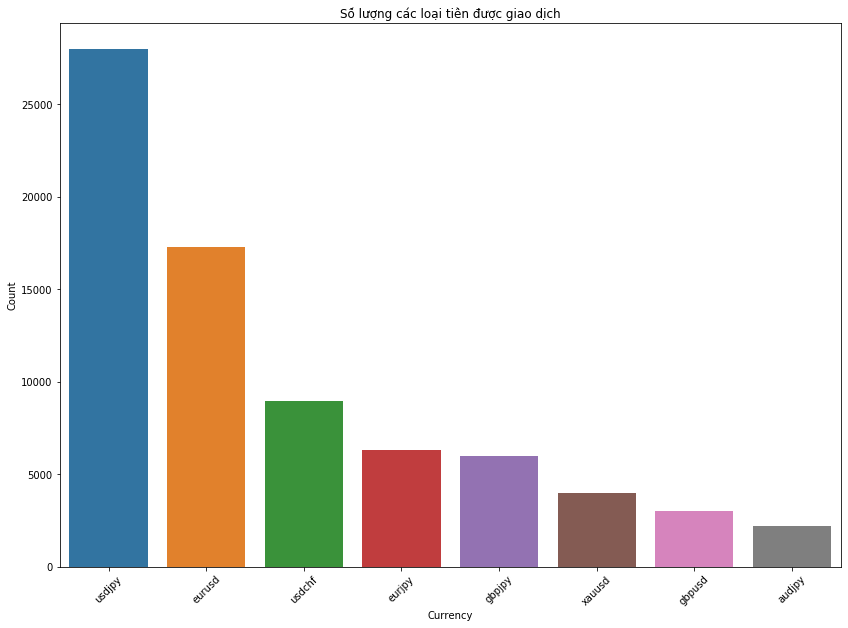

In [23]:
plt.figure(figsize=(14,10))
sb.barplot(data=df_symbol,x="Currency",y="Count")
plt.title("Số lượng các loại tiền được giao dịch")
plt.xticks(rotation=45)
plt.show()

In [25]:
df_crosstab = pd.crosstab(df_analyze.Symbol,df_analyze.Target).reset_index()
df_crosstab['normal_percent'] = round((df_crosstab[0]/df_crosstab[0].sum())*100,2)
df_crosstab['cheat_percent'] = round((df_crosstab[1]/df_crosstab[1].sum())*100,2)

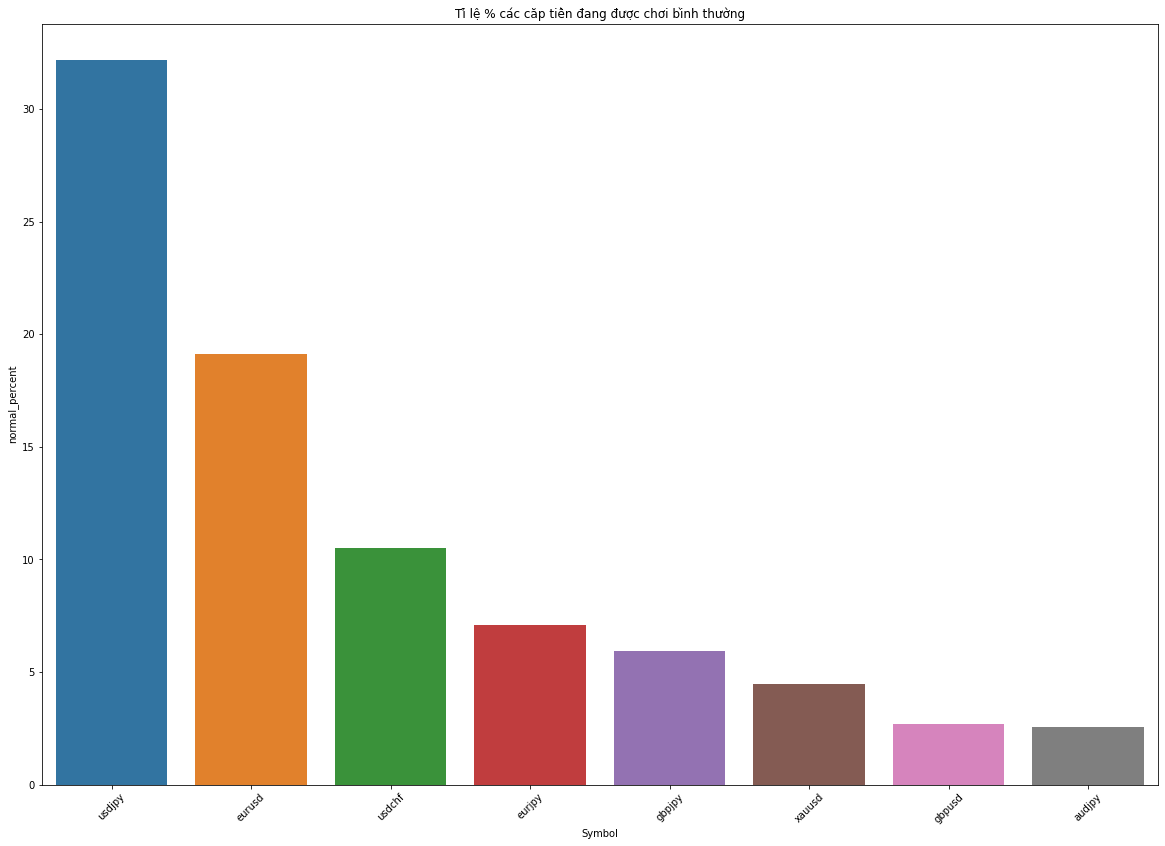

In [31]:
plt.figure(figsize=(20,14))
sb.barplot(data=df_crosstab.sort_values(by=['normal_percent'],ascending=False).head(8),y="normal_percent",x="Symbol")
plt.xticks(rotation=45)
plt.title("Tỉ lệ % các căp tiền đang được chơi bình thường")
plt.show()

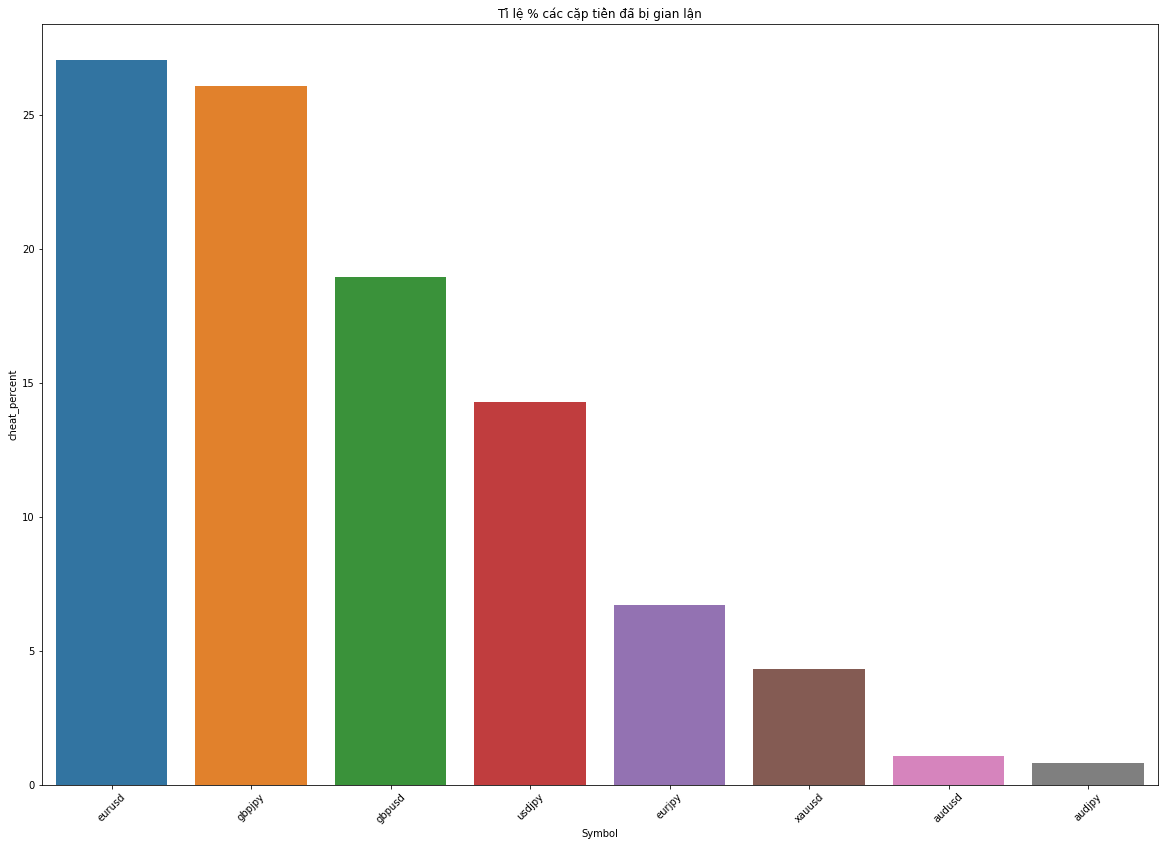

In [30]:
plt.figure(figsize=(20,14))
sb.barplot(data=df_crosstab.sort_values(by=['cheat_percent'],ascending=False).head(8),y="cheat_percent",x="Symbol")
plt.xticks(rotation=45)
plt.title("Tỉ lệ % các cặp tiền đã bị gian lận")
plt.show()

### Phân tích biến Symbol
    1. Các cặp tiền bị gian lận nhiều nhất ta thấy đều liên quan đến các loại tiền EUR, GBP, USD là những loại tiền được chơi nhiều nhất và có sự biến động lớn nhất. Dễ dàng kiếm lời nhất so với các loại tiền khác.

## Phân tích 2 biến Bonus và Balance

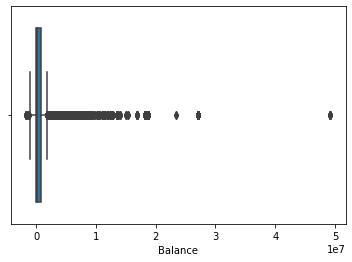

In [33]:
sb.boxplot(df_analyze.Balance)

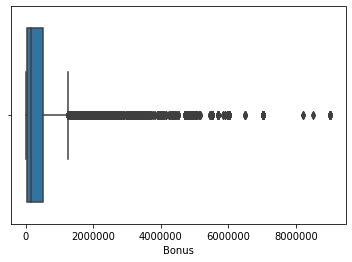

In [32]:
sb.boxplot(df_analyze.Bonus)

In [10]:
lower,upper,df_now,df_index = pt.xem_ngoai_le(df_analyze,'Bonus')
print("Lower bonus : {} , Upper bonus : {}".format(lower,upper))
lower,upper,df_now,df_index = pt.xem_ngoai_le(df_analyze,'Balance')
print("Lower balance : {} , Upper balance : {}".format(lower,upper))

Lower bonus : -715000.0 , Upper bonus : 1245000.0
Lower balance : -1046275.5 , Upper balance : 1828024.5


In [6]:
df_temp = df[['Balance','Bonus',"Volume"]]
print(df_temp.corr())

          Balance     Bonus    Volume
Balance  1.000000  0.584551  0.117000
Bonus    0.584551  1.000000  0.228564
Volume   0.117000  0.228564  1.000000


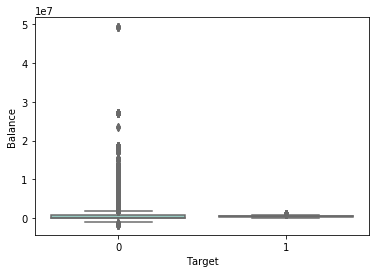

In [8]:
sb.boxplot(x='Target',y='Balance',data=df_analyze,palette="Set3")

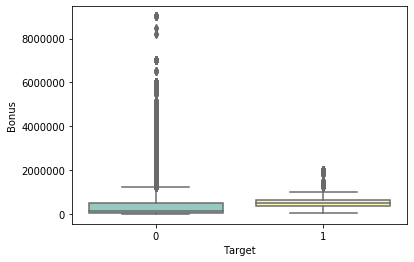

In [9]:
sb.boxplot(x='Target',y='Bonus',data=df_analyze,palette="Set3")

### Kết luận phân tích trên 2 biến Balance và Bonus
    1. 2 Biến này không có liên quan đến biến Volume. Dường như không có sự liên quan giữa số lượng tiền nộp và tiền thưởng trong số lượng Volume mà các account sẽ đặt.
    2. Quan sát 2 biến Bonus và Balance trên từng class thì ta thấy 2 biến trên đều nằm trong khoảng trung bình của 2 biến trên. Điều này không lạ, trong 1 sàn giao dịch forex thì số lượng đặt volume thường được giới hạn trong 1 khoảng nhất định theo từng loại tiền. VD: với EURJPY thì sàn giao dịch sẽ giới hạn chỉ được giao dịch với VOLUME 30 trong cùng 1 thời điểm. Vì vậy, các tất những giao dịch gian lận sẽ chỉ giao dịch trong 1 khoảng nhỏ vừa đủ để nhanh lấy được tiền lời từ giao dịch. Nếu các account gian lận nộp quá nhiều tiền và tiền thưởng thì sẽ rất lâu để có thể lấy được tiền lời.
    3. Không thể loại bỏ các ngoại lệ ở 2 biến trên. Chúng ta sẽ xem xét cách biến đổi sau.

# Xem xét độ giống nhau của những tài khoản gian lận và không gian lận
    1. Thông thường các giao dịch gian lận thông thường sẽ rất giống nhau ở một số yếu tố bao gồm loại tiền, volume, balance, bonus. Vì vậy distance có thể xem xét là một trong những yếu tố rất quan trọng để xem xét giao dịch ở một tài khoảng có gian lận hay không.

# Xem xét các giao dịch trên mức độ từng account

In [8]:
df_distance = df.copy()

In [9]:
df_distance = df_distance.merge(df_distance.groupby(by=['Account'])['Type'].count().reset_index(),how="inner",left_on=["Account"],right_on=["Account"],validate="many_to_one",copy=False)
df_distance.rename(columns={"Type_x":"Type","Type_y":"Num_of_order"},inplace=True)

In [10]:
df_distance.Time = pd.to_datetime(df_distance.Time)
now = datetime.now()
df_distance.Time = (now - df_distance.Time).dt.total_seconds()

In [11]:
df_distance = df_distance.merge(df_distance.groupby(by=['Account',"Type"])['Time'].median().reset_index(),how="inner",left_on=["Account","Type"],right_on=["Account","Type"],validate="many_to_one",copy=False)
df_distance.rename(columns={"Time_x":"Time","Time_y":"Time_median"},inplace=True)

In [12]:
df_distance = df_distance.merge(df_distance.groupby(by=['Account'])['Volume'].sum().reset_index(),how="inner",left_on=["Account"],right_on=["Account"],validate="many_to_one",copy=False)
df_distance.rename(columns={"Volume_x":"Volume","Volume_y":"Sum_of_vol"},inplace=True)

In [13]:
df_distance = df_distance.merge(df_distance.groupby(by=['Account',"Type","Symbol"])['Volume'].sum().reset_index(),how="inner",left_on=['Account',"Type","Symbol"],right_on=['Account',"Type","Symbol"],validate="many_to_one",copy=False)
df_distance.rename(columns={"Volume_x":"Volume","Volume_y":"Sum_of_vol_type"},inplace=True)

In [14]:
df_distance = df_distance.merge(df_distance.groupby(by=['Account'])['Symbol'].unique().map(lambda x: len(x)).reset_index(),how="inner",left_on=['Account'],right_on=['Account'],validate="many_to_one",copy=False)
df_distance.rename(columns={"Symbol_x":"Symbol","Symbol_y":"Num_of_sym"},inplace=True)

In [15]:
df_distance = df_distance.merge(df_distance.groupby(by=['Account','Type'])['Volume'].median().reset_index(),how="inner",left_on=["Account",'Type'],right_on=["Account",'Type'],validate="many_to_one",copy=False)
df_distance.rename(columns={"Volume_x":"Volume","Volume_y":"Volume_median"},inplace=True)

In [16]:
df_distance.reset_index(drop=True,inplace=True)

In [17]:
df_distance.head()

,Account,Ticket,Time,Type,Volume,Symbol,Open Price,S / L,T / P,Close Time,...,Profit,Balance,Bonus,Target,Num_of_order,Time_median,Sum_of_vol,Sum_of_vol_type,Num_of_sym,Volume_median
0,5353407,61928436.0,1.241624e+06,buy,3.0,usdjpy,103.460,103.3,0.0,2020.11.09 14:00:41,...,216 300,500000.0,1000000.0,1,11,1.241624e+06,41.0,3.0,1,3.0
1,5353407,61953817.0,1.217519e+06,sell,4.0,usdjpy,104.179,0.0,0.0,2020.11.09 16:49:32,...,-422 400,500000.0,1000000.0,1,11,1.214131e+06,41.0,38.0,1,4.0
2,5353407,61966332.0,1.214140e+06,sell,4.0,usdjpy,104.860,0.0,0.0,2020.11.09 16:53:44,...,-160 400,500000.0,1000000.0,1,11,1.214131e+06,41.0,38.0,1,4.0
3,5353407,61966335.0,1.214137e+06,sell,4.0,usdjpy,104.859,0.0,0.0,2020.11.09 16:53:42,...,-162 800,500000.0,1000000.0,1,11,1.214131e+06,41.0,38.0,1,4.0
4,5353407,61966341.0,1.214135e+06,sell,4.0,usdjpy,104.854,0.0,0.0,2020.11.09 16:53:15,...,-160 400,500000.0,1000000.0,1,11,1.214131e+06,41.0,38.0,1,4.0


In [18]:
df_analyze = df_distance[['Target','Num_of_order','Sum_of_vol','Sum_of_vol_type','Num_of_sym','Volume_median','Account']]

## Phân tích biến Num_of_order số lượng giao dịch trong 1 account được giao dịch trong 1 thời điểm

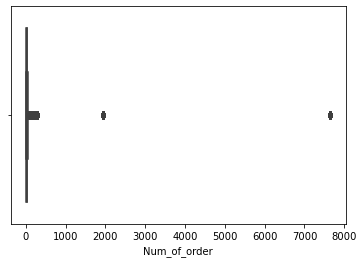

In [19]:
sb.boxplot(df_analyze.Num_of_order)

In [20]:
lower,upper,df_now,df_index = pt.xem_ngoai_le(df_analyze,'Num_of_order')
print("Lower Num_of_order : {} , Upper Num_of_order : {}".format(lower,upper))

Lower Num_of_order : -30.0 , Upper Num_of_order : 66.0


In [37]:
df_analyze = df_analyze[df_analyze.Num_of_order<=66]

In [38]:
df_analyze[df_analyze.Target==1].Num_of_order.describe()

count    3459.000000
mean        9.746459
std         6.095506
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        31.000000
Name: Num_of_order, dtype: float64

In [39]:
df_analyze[df_analyze.Target==0].Num_of_order.describe()

count    68823.000000
mean        14.567586
std         11.897136
min          1.000000
25%          5.000000
50%         11.000000
75%         23.000000
max         66.000000
Name: Num_of_order, dtype: float64

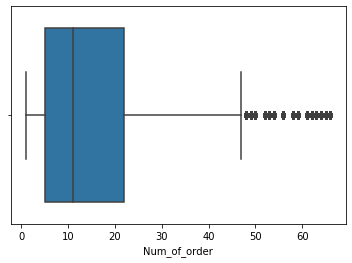

In [40]:
sb.boxplot(df_analyze.Num_of_order)

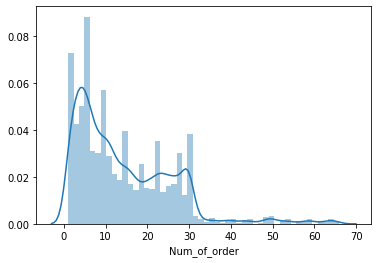

In [42]:
sb.distplot(df_analyze.Num_of_order)

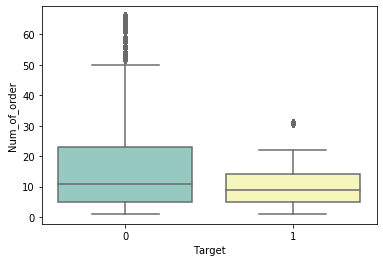

In [43]:
sb.boxplot(x='Target',y='Num_of_order',data=df_analyze,palette="Set3")

In [44]:
st = "Num_of_order" + "~ C(" + "Target" + ")"
model =ols(st,data=df_analyze[['Num_of_order','Target']]).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print(anova_table)

                 sum_sq       df           F         PR(>F)
C(Target)  7.655108e+04      1.0  560.617377  1.826728e-123
Residual   9.869676e+06  72280.0         NaN            NaN


### Kết luận về biến Num_of_order
    1. Chúng ta sẽ loại bỏ tất cả các ngoại lệ ở biến này. Những người chơi với số lượng rất nhiều giao dịch trong 1 lần gần như không có khả năng gian lận và chúng giao dịch ở VOLUME rất nhỏ có thể gây ảnh hưởng đến mô hình.
    2. Ta thấy được các tài khoản gian lận thường mở ít hơn so với các tài khoản không gian lận. Khối lượng mở sẽ lớn hơn để đảm bảo chắc chắn có lời.

## Phân tích biến Sum_of_vol số lượng giao dịch trong 1 account được giao dịch trong 1 thời điểm

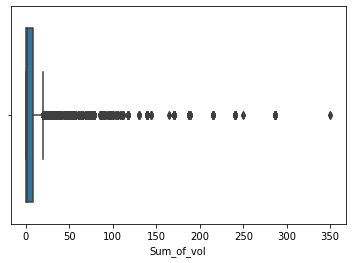

In [21]:
sb.boxplot(df_analyze.Sum_of_vol)

In [46]:
df_analyze.Sum_of_vol.describe()

count    72282.000000
mean         5.808771
std         15.542490
min          0.010000
25%          0.270000
50%          0.950000
75%          4.360000
max        313.000000
Name: Sum_of_vol, dtype: float64

In [47]:
df_analyze[df_analyze.Target==1].Sum_of_vol.describe()

count    3459.000000
mean       18.270705
std         8.733965
min         2.000000
25%        13.000000
50%        18.000000
75%        20.000000
max        88.000000
Name: Sum_of_vol, dtype: float64

In [48]:
df_analyze[df_analyze.Target==0].Sum_of_vol.describe()

count    68823.000000
mean         5.182442
std         15.546053
min          0.010000
25%          0.260000
50%          0.840000
75%          3.400000
max        313.000000
Name: Sum_of_vol, dtype: float64

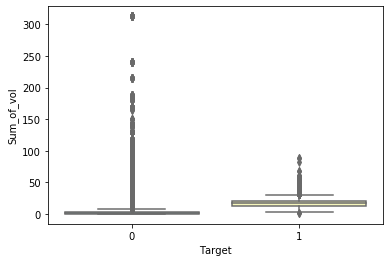

In [49]:
sb.boxplot(x='Target',y='Sum_of_vol',data=df_analyze,palette="Set3")

In [50]:
st = "Sum_of_vol" + "~ C(" + "Target" + ")"
model =ols(st,data=df_analyze[['Sum_of_vol','Target']]).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print(anova_table)

                 sum_sq       df            F  PR(>F)
C(Target)  5.641805e+05      1.0  2413.432165     0.0
Residual   1.689667e+07  72280.0          NaN     NaN


### Kết luận phân tích Sum_of_vol
    1. Tổng số Volume được giao dịch trong các tài khoảng gian lận thường rất cao so với so với các tài khoản thường với Q1 và Q3 nằm trong khoảng từ 13 đến 20. Có ngoại lệ max là 88 là những tài khoản gian lận ở các cặp tiền không thường gặp. Và rất ít gặp.
    2. Chúng ta không thể loại bỏ ngoại lệ ở biến này bởi vì các ngoại lệ này chính là các tài khoản gian lận.

## Phân tích biến Num_of_sym số loại tiền trong 1 account được giao dịch trong 1 thời điểm

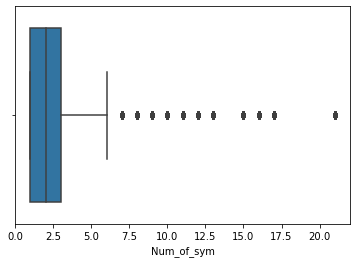

In [22]:
sb.boxplot(df_analyze.Num_of_sym)

In [19]:
df_analyze.Num_of_sym.describe()

count    88140.000000
mean         2.319662
std          2.168119
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         24.000000
Name: Num_of_sym, dtype: float64

In [23]:
lower,upper,df_now,df_index = pt.xem_ngoai_le(df_analyze,'Num_of_sym')
print("Lower Num_of_sym : {} , Upper Num_of_sym : {}".format(lower,upper))

Lower Num_of_sym : -2.0 , Upper Num_of_sym : 6.0


In [21]:
df_analyze[df_analyze.Target==1].Num_of_sym.describe()

count    3459.000000
mean        1.943336
std         1.356485
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: Num_of_sym, dtype: float64

In [22]:
df_analyze[df_analyze.Target==0].Num_of_sym.describe()

count    84681.000000
mean         2.335034
std          2.193535
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         24.000000
Name: Num_of_sym, dtype: float64

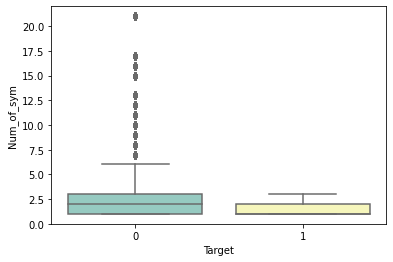

In [24]:
sb.boxplot(x='Target',y='Num_of_sym',data=df_analyze,palette="Set3")

In [34]:
st = "Num_of_sym" + "~ C(" + "Target" + ")"
model =ols(st,data=df_analyze[['Num_of_sym','Target']]).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print(anova_table)

                  sum_sq       df           F        PR(>F)
C(Target)     509.876897      1.0  108.599784  2.054726e-25
Residual   413808.649028  88138.0         NaN           NaN


## Kết luận về biến Num_of_sym
    1. Chúng ta sẽ loại bỏ ngoại lệ ở biến này sau khi ở cả 2 class. Phần lớn là những giao dịch không có gian lận, ở tài khoản gian lận thì rất khó phân biệt được gian lận nếu không được xem xét qua một nhân viên chuyên nghiệp.

## Phân tích biến Volume_median trung vị VOLUME trong 1 account được giao dịch trong 1 thời điểm

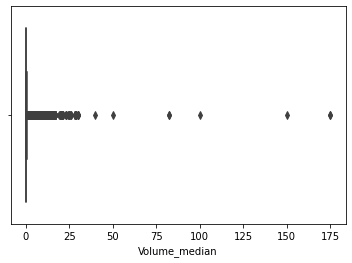

In [25]:
sb.boxplot(df_analyze.Volume_median)

In [26]:
lower,upper,df_now,df_index = pt.xem_ngoai_le(df_analyze,'Volume_median')
print("Lower Volume_median : {} , Upper Volume_median : {}".format(lower,upper))

Lower Volume_median : -0.275 , Upper Volume_median : 0.48500000000000004


In [37]:
df_analyze[df_analyze.Target==1].Volume_median.describe()

count    3459.000000
mean        3.252333
std         4.419163
min         0.050000
25%         1.000000
50%         2.000000
75%         4.000000
max        82.000000
Name: Volume_median, dtype: float64

In [38]:
df_analyze[df_analyze.Target==0].Volume_median.describe()

count    84681.000000
mean         0.409540
std          1.592885
min          0.010000
25%          0.010000
50%          0.040000
75%          0.200000
max         99.000000
Name: Volume_median, dtype: float64

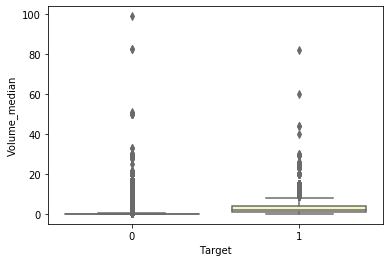

In [39]:
sb.boxplot(x='Target',y='Volume_median',data=df_analyze,palette="Set3")

### Kết Luận biến volume_median
    1. Chúng ta sử dụng volume median để có được vị trí phân nữa số volume để tránh trường hợp 1 tài khoản mở rất nhiều lệnh nhỏ và một lệnh rất lớn, gây ra sự sai biệt trong mô hình.
    2. Ở class gian lận thì trung vị volume thường lớn hơn so với các class không gian lận với Vị trí Q2 class 0 là 0.040000 ngược lại ở class 1 là 2.
    3. Chúng ta cũng sẽ đưa biến này vào mô hình thay cho biến Volume chỉ biểu diễn Volume cho 1 lệnh, không hiển thị cho 1 account.

# Kết luận cuối cùng
    1. Chúng ta sẽ loại bỏ ngoại lệ ở biến Num_of_order với upper là 66.
    2. Loại bỏ ngoại lệ ở biến Num_of_sym với upper là 6.
    3. Các giao dịch gian lận thì sẽ thường mở ít giao dịch trong cùng 1 lần, với volume trung bình rất lớn trong khoảng từ 1-4, với balance và bonus nhỏ, và các cặp tiền thường được giao dịch có chứa EUR,GPB,USD,JPY là những cặp tiền có biến động tỉ giá trên profit lớn

In [27]:
print(" Số lượng record trước khi loại bỏ ngoại lệ : ",df_distance.shape[0])

 Số lượng record trước khi loại bỏ ngoại lệ :  87265


In [28]:
df_distance = df_distance[df_distance.Num_of_order<=66]
df_distance = df_distance[df_distance.Num_of_sym<=6]

In [29]:
print(" Số lượng record sau khi loại bỏ ngoại lệ : ",df_distance.shape[0])

 Số lượng record sau khi loại bỏ ngoại lệ :  66513


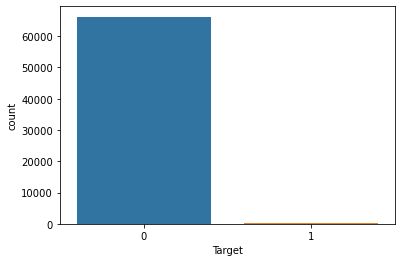

In [30]:
sb.countplot(data=df_distance,x="Target")

In [31]:
df_distance['Bal_on_bonus'] = df_distance['Balance']/(df_distance['Bonus'] + 1)

In [17]:
df_distance.columns

Index(['Account', 'Ticket', 'Time', 'Type', 'Volume', 'Symbol', 'Open Price',
       'S / L', 'T / P', 'Close Time', 'Close Price', 'Commission', 'Taxes',
       'Swap', 'Profit', 'Balance', 'Bonus', 'Target', 'Num_of_order',
       'Time_median', 'Sum_of_vol', 'Sum_of_vol_type', 'Num_of_sym',
       'Volume_median', 'Bal_on_bonus'],
      dtype='object')

In [32]:
df_modeling = df_distance.groupby(by=['Account','Type','Symbol']).head(1)

In [33]:
X = df_modeling[['Volume_median','Symbol','Balance','Bonus','Num_of_order','Num_of_sym','Sum_of_vol','Sum_of_vol_type','Bal_on_bonus']]
Y = df_modeling.Target

In [34]:
ct = ColumnTransformer([('encoder', OneHotEncoder(categories=[X.Symbol.unique()],handle_unknown='ignore'), [1])],remainder='passthrough')

In [35]:
ct.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OneHotEncoder(categories=[array(['usdjpy', 'xauusd', 'gbpjpy', 'eurusd', 'gbpusd', 'eurjpy',
       'eurchf', 'audcad', 'euraud', 'audusd', 'usdsgd', 'gbpaud',
       'audjpy', 'usdtry', 'audchf', 'chfjpy', 'dowusd', 'eurnzd',
       'gbpcad', 'gbpnzd', 'nasusd', 'usdchf', 'usdzar', 'eurzar',
       'xagusd', 'audnzd', 'gbpchf', 'nzdjpy', 'cadjpy', 'eurgbp',
       'usdcad', 'eurcad', 'nzdusd', 'esxeur', 's&pusd', 'usdmxn',
       'usdcnh', 'usdjpym', 'eurusdm', 'gbpusdm', 'ftxgbp', 'audusdm',
       'usdchfm', 'eurusd.cn', 'wtiusd', 'gbpjpym', 'caceur', 'daxeur',
       'eurnzd.cn', 'hsxhkd'], dtype=object)],
                                               handle_unknown='ignore'),
                                 [1])])

In [36]:
filename = 'onehotencoder_transformer_bonus_2_23112020.pkl'
pickle.dump(ct, open(filename, 'wb'))

In [37]:
X_transform = ct.transform(X).toarray()

In [38]:
X_train,X_test,Y_train,Y_test = mt.chia_bo_du_lieu(X_transform,Y,0.3)

In [39]:
nb_md = md.naive_bayes_model_build(X_train,Y_train)
log_md = md.logistic_model_build(X_train,Y_train)
dec_md = md.DecisionTree_classify_model_build(X_train,Y_train)
rdf_md = md.RandomForest_classification(X_train,Y_train)

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
print("Naive Bayer classify report : \n" + classification_report(Y_test,nb_md.predict(X_test)))

Naive Bayer classify report : 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6767
           1       0.06      0.86      0.11        29

    accuracy                           0.94      6796
   macro avg       0.53      0.90      0.54      6796
weighted avg       1.00      0.94      0.97      6796



In [41]:
print("Logistic classify report : \n" + classification_report(Y_test,log_md.predict(X_test)))

Logistic classify report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6767
           1       0.60      0.31      0.41        29

    accuracy                           1.00      6796
   macro avg       0.80      0.65      0.70      6796
weighted avg       1.00      1.00      1.00      6796



In [42]:
print("Decision Tree classify report : \n" + classification_report(Y_test,dec_md.predict(X_test)))

Decision Tree classify report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6767
           1       0.78      0.86      0.82        29

    accuracy                           1.00      6796
   macro avg       0.89      0.93      0.91      6796
weighted avg       1.00      1.00      1.00      6796



In [43]:
print("Random Forest classify report : \n" + classification_report(Y_test,rdf_md.predict(X_test)))

Random Forest classify report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6767
           1       0.83      0.86      0.85        29

    accuracy                           1.00      6796
   macro avg       0.92      0.93      0.92      6796
weighted avg       1.00      1.00      1.00      6796



In [44]:
pt.danh_gia_mo_hinh_logistic(Y_test,dec_md.predict(X_test))

- Precision and Recall Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6767
           1       0.78      0.86      0.82        29

    accuracy                           1.00      6796
   macro avg       0.89      0.93      0.91      6796
weighted avg       1.00      1.00      1.00      6796

- Confusion Metric
[[6760    7]
 [   4   25]]


In [45]:
pt.danh_gia_mo_hinh_logistic(Y_test,rdf_md.predict(X_test))

- Precision and Recall Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6767
           1       0.83      0.86      0.85        29

    accuracy                           1.00      6796
   macro avg       0.92      0.93      0.92      6796
weighted avg       1.00      1.00      1.00      6796

- Confusion Metric
[[6762    5]
 [   4   25]]


In [46]:
print("Random forest classification accuracy :",rdf_md.score(X_test,Y_test))

Random forest classification accuracy : 0.9986756915832843


In [47]:
print("Decision Tree classification accuracy :",dec_md.score(X_test,Y_test))

Decision Tree classification accuracy : 0.9983814008240142


In [96]:
df_modeling[df_modeling.Target==1][['Volume_median','Symbol','Balance','Bonus','Num_of_order','Num_of_sym','Sum_of_vol','Sum_of_vol_type','Bal_on_bonus']]

,Volume_median,Symbol,Balance,Bonus,Num_of_order,Num_of_sym,Sum_of_vol,Sum_of_vol_type,Bal_on_bonus
0,2.0,usdjpy,900000.0,910000.0,9,1,25.0,25.0,1.989011
9,2.0,eurusd,600000.0,600000.0,10,1,20.0,20.0,2.000000
19,5.0,eurusd,800000.0,800000.0,8,1,40.0,40.0,2.000000
27,20.0,gbpusd,1000000.0,1000000.0,1,1,20.0,20.0,2.000000
28,13.0,usdjpy,500000.0,500000.0,1,1,13.0,13.0,2.000000
...,...,...,...,...,...,...,...,...,...
3493,3.5,gbpusd,900000.0,1820000.0,8,2,30.0,12.0,1.494505
3497,3.5,gbpjpy,900000.0,1820000.0,8,2,30.0,18.0,1.494505
3501,3.5,gbpusd,900000.0,1820000.0,8,2,30.0,12.0,1.494505
3505,25.0,gbpjpy,1000000.0,2020000.0,1,1,25.0,25.0,1.495050


In [71]:
df_modeling[(df_modeling.Target==0) & (df_modeling.Y_hat==1)]

,Account,Ticket,Time,Type,Volume,Symbol,Open Price,S / L,T / P,Close Time,...,Bonus,Target,Num_of_order,Time_median,Sum_of_vol,Sum_of_vol_type,Num_of_sym,Volume_median,Bal_on_bonus,Y_hat
21185,5374268,NaN,5.017706e+05,buy,1.00,usdjpy,104.60200,0.0,0.0,0,...,200000.0,0,8,5.063146e+05,8.00,4.00,1,1.00,1.856990,1
24291,5359031,NaN,5.221576e+05,buy,9.90,usdjpy,104.43400,0.0,0.0,0,...,200712.0,0,1,5.221576e+05,9.90,9.90,1,9.90,4.331455,1
24464,5372765,NaN,5.239336e+05,sell,10.00,s&pusd,3613.18000,0.0,0.0,0,...,700000.0,0,6,8.145406e+05,39.00,30.00,2,10.00,1.500000,1
28777,5374240,NaN,7.871716e+05,buy,2.00,gbpjpy,138.05500,0.0,0.0,0,...,1460000.0,0,6,7.874931e+05,10.00,10.00,1,2.00,1.500000,1
29603,5182754,NaN,7.056658e+06,buy,1.00,eurusd,1.19072,0.0,0.0,0,...,1200000.0,0,7,1.765912e+07,5.50,2.00,3,0.75,3.042746,1
30826,5263380,NaN,8.302058e+06,buy,0.15,eurusd,1.19020,0.0,0.0,0,...,3000000.0,0,24,1.298890e+07,26.81,8.35,5,1.00,1.478566,1
31368,5344874,NaN,1.048442e+06,buy,3.00,nasusd,11803.38000,0.0,0.0,0,...,1130967.0,0,4,1.072581e+06,26.00,6.00,2,3.00,1.270575,1
42100,200135389,NaN,4.633536e+05,buy limit,5.00,gbpusd,1.32000,0.0,0.0,0,...,400000.0,0,2,4.633536e+05,10.00,5.00,2,5.00,1.500000,1
50482,200142264,NaN,1.996416e+06,buy limit,0.50,eurjpy,120.94600,0.0,0.0,0,...,800000.0,0,12,1.996416e+06,4.50,0.50,1,0.50,2.249391,1
50707,200077631,NaN,8.155456e+05,sell,0.01,gbpjpy,137.90100,0.0,0.0,0,...,42634.0,0,8,7.633336e+05,4.04,0.01,3,0.01,1.322231,1


In [73]:
df_modeling[(df_modeling.Target==0) & (df_modeling.Y_hat_rdf==1)]

,Account,Ticket,Time,Type,Volume,Symbol,Open Price,S / L,T / P,Close Time,...,Target,Num_of_order,Time_median,Sum_of_vol,Sum_of_vol_type,Num_of_sym,Volume_median,Bal_on_bonus,Y_hat,Y_hat_rdf
7797,5338978,NaN,4.623356e+05,sell,10.0,gbpusd,1.32110,0.0,0.0,0,...,0,2,4.849246e+05,10.01,10.0,2,5.005,0.990984,0,1
24917,5369306,NaN,5.321226e+05,buy,5.0,gbpusd,1.32178,0.0,0.0,0,...,0,4,5.321666e+05,20.00,20.0,1,5.000,1.495050,0,1
28777,5374240,NaN,7.871716e+05,buy,2.0,gbpjpy,138.05500,0.0,0.0,0,...,0,6,7.874931e+05,10.00,10.0,1,2.000,1.500000,1,1
29636,5373659,NaN,8.607976e+05,buy,0.5,gbpjpy,138.91200,0.0,0.0,0,...,0,9,8.693366e+05,11.00,11.0,1,1.000,1.492647,0,1
33868,14840,NaN,8.786571e+06,buy,4.0,nzdusd,0.65891,0.0,0.0,0,...,0,1,8.786571e+06,4.00,4.0,1,4.000,2.000000,0,1
38608,200124512,NaN,4.586766e+05,buy,1.0,dowusd,29860.30000,0.0,0.0,0,...,0,6,4.623766e+05,6.00,6.0,1,1.000,1.995850,0,1
38838,200144965,NaN,4.591226e+05,sell,10.0,gbpusd,1.32204,0.0,0.0,0,...,0,2,4.617406e+05,20.00,20.0,1,10.000,1.000000,0,1
42100,200135389,NaN,4.633536e+05,buy limit,5.0,gbpusd,1.32000,0.0,0.0,0,...,0,2,4.633536e+05,10.00,5.0,2,5.000,1.500000,1,1
56980,200160849,NaN,5.096156e+05,buy,5.0,gbpjpy,138.29700,0.0,0.0,0,...,0,5,5.099601e+05,10.07,10.0,2,5.000,1.962890,1,1


In [79]:
df_modeling[(df_modeling.Target==1) & (df_modeling.Y_hat_rdf==0)]

,Account,Ticket,Time,Type,Volume,Symbol,Open Price,S / L,T / P,Close Time,...,Target,Num_of_order,Time_median,Sum_of_vol,Sum_of_vol_type,Num_of_sym,Volume_median,Bal_on_bonus,Y_hat,Y_hat_rdf
571,200111234,42384055.0,2.437797e+07,buy,8.00,usdjpy,109.7920,109.12,110.392,NaN,...,1,1,2.437797e+07,8.00,8.00,1,8.000,1.500000,0,0
605,200075521,38954809.0,2.944237e+07,sell,9.99,gbpjpy,143.8700,0.00,143.140,NaN,...,1,3,2.343755e+07,35.29,22.29,1,11.145,2.273973,0,0
715,5354392,60692307.0,4.654964e+06,buy,1.00,gbpjpy,135.9210,135.15,136.650,2020.09.30 09:08:56,...,1,2,4.654829e+06,5.00,5.00,1,2.500,1.882353,0,0
937,200146263,NaN,9.853574e+06,sell,2.00,usdjpy,104.5000,0.00,0.000,NaN,...,1,9,9.584765e+06,12.00,12.00,1,1.000,2.010966,0,0
1018,200193949,NaN,9.875439e+06,buy,1.00,usdjpy,104.2240,0.00,0.000,NaN,...,1,10,9.589933e+06,12.50,12.50,1,1.000,2.061280,0,0
1028,200146270,NaN,9.850539e+06,sell,2.00,usdjpy,104.7100,0.00,0.000,NaN,...,1,8,9.552958e+06,12.45,12.45,1,1.725,2.028062,0,0
1129,200180934,48751212.0,1.889034e+07,sell,2.00,usdjpy,107.5130,108.59,106.878,2020.04.28 12:19:13,...,1,9,1.863748e+07,11.50,11.50,1,1.000,1.928571,0,0
1178,200191412,52143736.0,1.543150e+07,sell,2.00,usdjpy,107.7080,0.00,106.945,2020.06.02 15:07:48,...,1,9,1.535649e+07,14.50,14.50,1,2.000,1.975610,0,0
1260,5361832,61131103.0,3.391985e+06,sell,2.00,usdtry,7.9211,0.00,7.800,NaN,...,1,7,3.391929e+06,14.00,14.00,1,2.000,1.994380,0,0


In [48]:
rdf_ada = RandomForestClassifier()

In [49]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=rdf_ada)

In [50]:
clf.fit(X_train,Y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier())

In [51]:
print("Adaboost with random forest classification accuracy :",clf.score(X_test,Y_test))

Adaboost with random forest classification accuracy : 0.9989699823425544


In [52]:
pt.danh_gia_mo_hinh_logistic(Y_test,clf.predict(X_test))

- Precision and Recall Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6767
           1       0.87      0.90      0.88        29

    accuracy                           1.00      6796
   macro avg       0.93      0.95      0.94      6796
weighted avg       1.00      1.00      1.00      6796

- Confusion Metric
[[6763    4]
 [   3   26]]


# Kết luận cuối cùng
    1. Ta sử dụng mô hình với random forest với adaboost với độ chính xác là 99%. Và Class 0 [Precision = 1, recall = 1], Class 1 [Precision = 0.98, recall = 0.96]
    2. Xem xét các record thường bị lẫn lộn trong class 1 thì ta thấy được các giao dịch gian lận có số lượng number of order khá là cao với volume khá thấp chỉ bằng 1, 0.5. Rất dễ làm cho mô hình bị lẫn lộn với giao dịch thường.
    3. Các giao dịch bình thường sử bị lẫn lộn là gian lận thực chất là rất giống với giao dịch gian lận. Nên việc mô hình bị lẫn lộn là khá bình thường. Vì việc đánh giá gian lận hay không không chỉ phụ thuộc vào 1 giao dịch mà còn lịch sử các giao dịch trong tài khoản đó nữa. Và việc này rất cảm tính nên khó có thể chính xác 100%.

In [53]:
# lưu lại random forest model
filename = 'ada_random_forest__2_bonus_23112020.sav'
pickle.dump(clf, open(filename, 'wb'))